In [1]:
import re
import numpy as np
import pandas as pd
import collections
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.cross_validation import train_test_split
from unidecode import unidecode
from nltk.util import ngrams
from tqdm import tqdm
import time

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
permulaan = [
    'bel',
    'se',
    'ter',
    'men',
    'meng',
    'mem',
    'memper',
    'di',
    'pe',
    'me',
    'ke',
    'ber',
    'pen',
    'per',
]

hujung = ['kan', 'kah', 'lah', 'tah', 'nya', 'an', 'wan', 'wati', 'ita']

def naive_stemmer(word):
    assert isinstance(word, str), 'input must be a string'
    hujung_result = re.findall(r'^(.*?)(%s)$' % ('|'.join(hujung)), word)
    word = hujung_result[0][0] if len(hujung_result) else word
    permulaan_result = re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan[::-1])), word)
    permulaan_result.extend(re.findall(r'^(.*?)(%s)' % ('|'.join(permulaan)), word))
    mula = permulaan_result if len(permulaan_result) else ''
    if len(mula):
        mula = mula[1][1] if len(mula[1][1]) > len(mula[0][1]) else mula[0][1]
    return word.replace(mula, '')

In [3]:
def build_dataset(words, n_words):
    count = [['GO', 0], ['PAD', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 3)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary


def classification_textcleaning(string):
    string = re.sub(
        'http\S+|www.\S+',
        '',
        ' '.join(
            [i for i in string.split() if i.find('#') < 0 and i.find('@') < 0]
        ),
    )
    string = unidecode(string).replace('.', ' . ').replace(',', ' , ')
    string = re.sub('[^A-Za-z ]+', ' ', string)
    string = re.sub(r'[ ]+', ' ', string).strip()
    string = ' '.join(
        [i for i in re.findall('[\\w\']+|[;:\-\(\)&.,!?"]', string) if len(i)]
    )
    string = string.lower().split()
    string = [(naive_stemmer(word), word) for word in string]
    return (
        ' '.join([word[0] for word in string if len(word[0]) > 1]),
        ' '.join([word[1] for word in string if len(word[0]) > 1]),
    )


def str_idx(corpus, dic, maxlen, UNK = 3):
    X = np.zeros((len(corpus), maxlen))
    for i in range(len(corpus)):
        for no, k in enumerate(corpus[i].split()[:maxlen][::-1]):
            val = dic[k] if k in dic else UNK
            X[i, -1 - no] = val
    return X

In [5]:
df = pd.read_csv('dataset/sentiment-data-v2.csv')
Y = LabelEncoder().fit_transform(df.label)
df.head()

,label,text
0,Negative,Lebih-lebih lagi dengan kemudahan internet da...
1,Positive,boleh memberi teguran kepada parti tetapi perl...
2,Negative,Adalah membingungkan mengapa masyarakat Cina b...
3,Positive,Kami menurunkan defisit daripada 6.7 peratus p...
4,Negative,"Ini masalahnya. Bukan rakyat, tetapi sistem"


In [6]:
with open('dataset/polarity-negative-translated.txt','r') as fopen:
    texts = fopen.read().split('\n')
labels = [0] * len(texts)

with open('dataset/polarity-positive-translated.txt','r') as fopen:
    positive_texts = fopen.read().split('\n')
labels += [1] * len(positive_texts)
texts += positive_texts
texts += df.iloc[:,1].tolist()
labels += Y.tolist()

assert len(labels) == len(texts)

In [7]:
for i in range(len(texts)):
    texts[i] = classification_textcleaning(texts[i])[0]

In [8]:
concat = ' '.join(texts).split()
vocabulary_size = len(list(set(concat)))
data, count, dictionary, rev_dictionary = build_dataset(concat, vocabulary_size)
print('vocab from size: %d'%(vocabulary_size))
print('Most common words', count[4:10])
print('Sample data', data[:10], [rev_dictionary[i] for i in data[:10]])

vocab from size: 13325
Most common words [('yang', 14899), ('tidak', 4588), ('untuk', 4038), ('filem', 3698), ('deng', 3350), ('ada', 3190)]
Sample data [1316, 196, 178, 98, 98, 126, 353, 4, 90, 210] ['ringkas', 'bodoh', 'bosan', 'kanak', 'kanak', 'lelaki', 'remaja', 'yang', 'begitu', 'muda']


In [10]:
class Model:
    def __init__(
        self,
        size_layer,
        num_layers,
        dimension_output,
        learning_rate,
        dropout,
        dict_size,
    ):
        def cells(size, reuse = False):
            return tf.contrib.rnn.DropoutWrapper(
                tf.nn.rnn_cell.LSTMCell(
                    size,
                    initializer = tf.orthogonal_initializer(),
                    reuse = reuse,
                ),
                state_keep_prob = dropout,
                output_keep_prob = dropout,
            )

        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None])
        encoder_embeddings = tf.Variable(
            tf.random_uniform([dict_size, size_layer], -1, 1)
        )
        encoder_embedded = tf.nn.embedding_lookup(encoder_embeddings, self.X)
        attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(
            num_units = size_layer, memory = encoder_embedded
        )
        rnn_cells = tf.contrib.seq2seq.AttentionWrapper(
            cell = tf.nn.rnn_cell.MultiRNNCell(
                [cells(size_layer) for _ in range(num_layers)]
            ),
            attention_mechanism = attention_mechanism,
            attention_layer_size = size_layer,
            alignment_history = True,
        )
        outputs, last_state = tf.nn.dynamic_rnn(
            rnn_cells, encoder_embedded, dtype = tf.float32
        )
        self.alignments = tf.transpose(
            last_state.alignment_history.stack(), [1, 2, 0]
        )
        W = tf.get_variable(
            'w',
            shape = (size_layer, dimension_output),
            initializer = tf.glorot_uniform_initializer(),
        )
        b = tf.get_variable(
            'b',
            shape = (dimension_output),
            initializer = tf.zeros_initializer(),
        )
        self.logits = tf.add(tf.matmul(outputs[:, -1], W), b, name = 'logits')
        self.cost = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits = self.logits, labels = self.Y
            )
        )
        self.optimizer = tf.train.AdamOptimizer(
            learning_rate = learning_rate
        ).minimize(self.cost)
        correct_pred = tf.equal(
            tf.argmax(self.logits, 1, output_type = tf.int32), self.Y
        )
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        self.attention = tf.nn.softmax(
            tf.reduce_sum(self.alignments[0], 1), name = 'alphas'
        )


In [11]:
size_layer = 256
num_layers = 2
dimension_output = 2
learning_rate = 1e-4
batch_size = 32
dropout = 0.8
maxlen = 80

tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Model(
    size_layer,
    num_layers,
    dimension_output,
    learning_rate,
    dropout,
    len(dictionary),
)
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver(tf.trainable_variables())
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [12]:
strings = ','.join(
    [
        n.name
        for n in tf.get_default_graph().as_graph_def().node
        if ('Variable' in n.op
        or 'Placeholder' in n.name
        or 'logits' in n.name
        or 'alphas' in n.name)
        and 'Adam' not in n.name
        and 'beta' not in n.name
    ]
)

In [13]:
strings.split(',')

['Placeholder',
 'Placeholder_1',
 'Variable',
 'memory_layer/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel',
 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias',
 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel',
 'rnn/attention_wrapper/bahdanau_attention/attention_v',
 'rnn/attention_wrapper/attention_layer/kernel',
 'w',
 'b',
 'logits',
 'gradients/logits_grad/Shape',
 'gradients/logits_grad/Shape_1',
 'gradients/logits_grad/BroadcastGradientArgs',
 'gradients/logits_grad/Sum',
 'gradients/logits_grad/Reshape',
 'gradients/logits_grad/Sum_1',
 'gradients/logits_grad/Reshape_1',
 'gradients/logits_grad/tuple/group_deps',
 'gradients/logits_grad/tuple/control_dependency',
 'gradients/logits_grad/tuple/control_dependency_1',
 'alphas']

In [14]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(13329, 256) dtype=float32_ref>,
 <tf.Variable 'memory_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/kernel:0' shape=(768, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_0/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/kernel:0' shape=(512, 1024) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/multi_rnn_cell/cell_1/lstm_cell/bias:0' shape=(1024,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/query_layer/kernel:0' shape=(256, 256) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/bahdanau_attention/attention_v:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'rnn/attention_wrapper/attention_layer/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'w:0' shape=(256, 2) dtype=float32_ref>,
 <tf.Variable 'b:0' shape=(2,

In [15]:
vectors = str_idx(texts, dictionary, maxlen)
train_X, test_X, train_Y, test_Y = train_test_split(
    vectors, labels, test_size = 0.2
)

In [16]:
from tqdm import tqdm
import time

EARLY_STOPPING, CURRENT_CHECKPOINT, CURRENT_ACC, EPOCH = 3, 0, 0, 0

while True:
    lasttime = time.time()
    if CURRENT_CHECKPOINT == EARLY_STOPPING:
        print('break epoch:%d\n' % (EPOCH))
        break

    train_acc, train_loss, test_acc, test_loss = 0, 0, 0, 0
    pbar = tqdm(
        range(0, len(train_X), batch_size), desc = 'train minibatch loop'
    )
    for i in pbar:
        batch_x = train_X[i : min(i + batch_size, train_X.shape[0])]
        batch_y = train_Y[i : min(i + batch_size, train_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost, _ = sess.run(
            [model.accuracy, model.cost, model.optimizer],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        assert not np.isnan(cost)
        train_loss += cost
        train_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    pbar = tqdm(range(0, len(test_X), batch_size), desc = 'test minibatch loop')
    for i in pbar:
        batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
        batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
        batch_x_expand = np.expand_dims(batch_x,axis = 1)
        acc, cost = sess.run(
            [model.accuracy, model.cost],
            feed_dict = {
                model.Y: batch_y,
                model.X: batch_x
            },
        )
        test_loss += cost
        test_acc += acc
        pbar.set_postfix(cost = cost, accuracy = acc)

    train_loss /= len(train_X) / batch_size
    train_acc /= len(train_X) / batch_size
    test_loss /= len(test_X) / batch_size
    test_acc /= len(test_X) / batch_size

    if test_acc > CURRENT_ACC:
        print(
            'epoch: %d, pass acc: %f, current acc: %f'
            % (EPOCH, CURRENT_ACC, test_acc)
        )
        CURRENT_ACC = test_acc
        CURRENT_CHECKPOINT = 0
    else:
        CURRENT_CHECKPOINT += 1

    print('time taken:', time.time() - lasttime)
    print(
        'epoch: %d, training loss: %f, training acc: %f, valid loss: %f, valid acc: %f\n'
        % (EPOCH, train_loss, train_acc, test_loss, test_acc)
    )
    EPOCH += 1


train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

epoch: 0, pass acc: 0.000000, current acc: 0.639706
time taken: 139.25777411460876
epoch: 0, training loss: 0.664084, training acc: 0.597270, valid loss: 0.642510, valid acc: 0.639706



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

epoch: 1, pass acc: 0.639706, current acc: 0.675070
time taken: 139.80784058570862
epoch: 1, training loss: 0.605703, training acc: 0.670374, valid loss: 0.619521, valid acc: 0.675070



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

epoch: 2, pass acc: 0.675070, current acc: 0.690826
time taken: 139.8586769104004
epoch: 2, training loss: 0.561371, training acc: 0.709248, valid loss: 0.610962, valid acc: 0.690826



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

epoch: 3, pass acc: 0.690826, current acc: 0.691877
time taken: 139.79384064674377
epoch: 3, training loss: 0.517386, training acc: 0.746282, valid loss: 0.617317, valid acc: 0.691877



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

epoch: 4, pass acc: 0.691877, current acc: 0.693978
time taken: 139.52493500709534
epoch: 4, training loss: 0.467056, training acc: 0.776136, valid loss: 0.637189, valid acc: 0.693978



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

time taken: 139.47107529640198
epoch: 5, training loss: 0.408898, training acc: 0.812297, valid loss: 0.683023, valid acc: 0.676471



train minibatch loop:   0%|          | 0/357 [00:00<?, ?it/s]

time taken: 125.94054365158081
epoch: 6, training loss: 0.339819, training acc: 0.850118, valid loss: 0.791616, valid acc: 0.674720



test minibatch loop: 100%|██████████| 90/90 [00:06<00:00, 14.21it/s, accuracy=0.75, cost=1.21]  

time taken: 82.36890912055969
epoch: 7, training loss: 0.273586, training acc: 0.884616, valid loss: 0.889613, valid acc: 0.671218

break epoch:8



In [17]:
real_Y, predict_Y = [], []

pbar = tqdm(
    range(0, len(test_X), batch_size), desc = 'validation minibatch loop'
)
for i in pbar:
    batch_x = test_X[i : min(i + batch_size, test_X.shape[0])]
    batch_y = test_Y[i : min(i + batch_size, test_X.shape[0])]
    predict_Y += np.argmax(
        sess.run(
            model.logits, feed_dict = {model.X: batch_x, model.Y: batch_y}
        ),
        1,
    ).tolist()
    real_Y += batch_y


validation minibatch loop: 100%|██████████| 90/90 [00:06<00:00, 14.39it/s]


In [18]:
print(
    metrics.classification_report(
        real_Y, predict_Y, target_names = ['negative', 'positive']
    )
)

             precision    recall  f1-score   support

   negative       0.63      0.69      0.66      1326
   positive       0.71      0.64      0.67      1530

avg / total       0.67      0.67      0.67      2856



In [19]:
text = classification_textcleaning('kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.33858103, 0.66141903]], dtype=float32)

In [20]:
text = classification_textcleaning('kerajaan sebenarnya sangat sayangkan rakyatnya')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.8111074 , 0.18889263]], dtype=float32)

In [21]:
text = classification_textcleaning('kerajaan sebenarnya sangat sayangkan rakyatnya, tetapi sebenarnya benci')
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
sess.run(tf.nn.softmax(model.logits), feed_dict={model.X:new_vector})

array([[0.9057085 , 0.09429152]], dtype=float32)

In [22]:
import json
with open('bahdanau-sentiment.json','w') as fopen:
    fopen.write(json.dumps({'dictionary':dictionary,'reverse_dictionary':rev_dictionary}))

In [23]:
saver.save(sess, 'bahdanau/model.ckpt')

'bahdanau/model.ckpt'

In [24]:
def freeze_graph(model_dir, output_node_names):

    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            'directory: %s' % model_dir
        )

    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    absolute_model_dir = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + '/frozen_model.pb'
    clear_devices = True
    with tf.Session(graph = tf.Graph()) as sess:
        saver = tf.train.import_meta_graph(
            input_checkpoint + '.meta', clear_devices = clear_devices
        )
        saver.restore(sess, input_checkpoint)
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,
            tf.get_default_graph().as_graph_def(),
            output_node_names.split(','),
        )
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [25]:
freeze_graph('bahdanau', strings)

INFO:tensorflow:Restoring parameters from bahdanau/model.ckpt
INFO:tensorflow:Froze 11 variables.
INFO:tensorflow:Converted 11 variables to const ops.
403 ops in the final graph.


In [26]:
def load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def)
    return graph

In [27]:
g = load_graph('bahdanau/frozen_model.pb')
x = g.get_tensor_by_name('import/Placeholder:0')
logits = g.get_tensor_by_name('import/logits:0')
alphas = g.get_tensor_by_name('import/alphas:0')
test_sess = tf.InteractiveSession(graph = g)
result = test_sess.run([logits, alphas], feed_dict = {x: new_vector})

/usr/local/lib/python3.5/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [29]:
news_string = 'kerajaan sebenarnya sangat bencikan rakyatnya, minyak naik dan segalanya'

In [30]:
text = classification_textcleaning(news_string)
new_vector = str_idx([text[0]], dictionary, len(text[0].split()))
result = test_sess.run([tf.nn.softmax(logits), alphas], feed_dict = {x: new_vector})

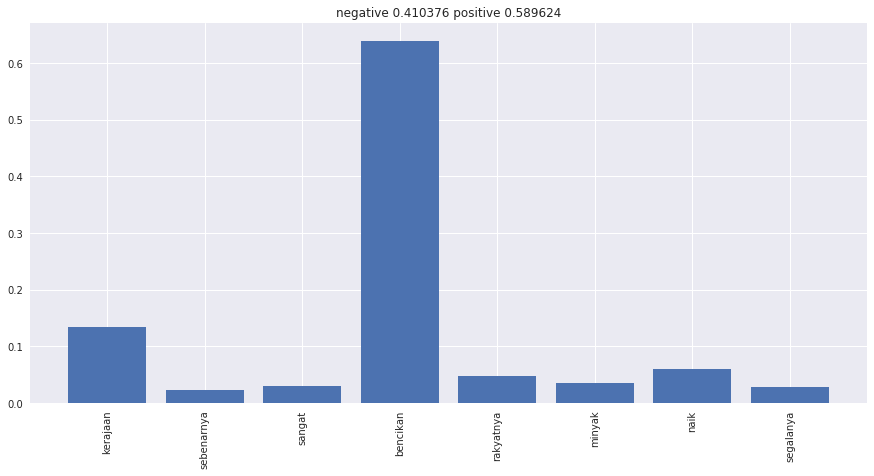

In [31]:
plt.figure(figsize = (15, 7))
labels = [word for word in text[1].split()]
val = [val for val in result[1]]
plt.bar(np.arange(len(labels)), val)
plt.xticks(np.arange(len(labels)), labels, rotation = 'vertical')
plt.title('negative %f positive %f' % (result[0][0,0], result[0][0,1]))
plt.show()